In [1]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install datasets


[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/491.4 kB ? eta -:--:--
     --------------- ---------------------- 194.6/491.4 kB 5.8 MB/s eta 0:00:01
     -------------------------------------- 491.4/491.4 kB 6.2 MB/s eta 0:00:00
  Using cached fsspec-2025.3.0-py3-none-any.whl (193 kB)
  Using cached dill-0.3.8-py3-none-any.whl (116 kB)
  Using cached aiohttp-3.11.18-cp310-cp310-win_amd64.whl (442 kB)
  Using cached pandas-2.2.3-cp310-cp310-win_amd64.whl (11.6 MB)
     ---------------------------------------- 0.0/25.8 MB ? eta -:--:--
      --------------------------------------- 0.4/25.8 MB 13.4 MB/s eta 0:00:02
     - -------------------------------------- 0.9/25.8 MB 13.7 MB/s eta 0:00:02
     -- ------------------------------------- 1.3/25.8 MB 11.8 MB/s eta 0:00:03
     -- ------------------------------------- 1.9/25.8 MB 11.8 MB/s eta 0:00:03
     --- ------------------------------------ 2.3/25.8 MB 12.1 MB/s eta 0:00:02
     ---- ----------------------------------- 2.8/25.8 M


[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import time
import torch
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

import torch
import time
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from datasets import load_dataset



In [6]:

# Load model and tokenizer
model_name = "gpt2"  # Replace with your LLM
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [7]:
import torch
import numpy as np
import time
import os
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from datasets import load_dataset

class QuantizedModelPipeline:
    def __init__(self, model_name, quantization_config=None, max_tokens=64):
        self.model_name = model_name
        self.quantization_config = quantization_config
        self.max_tokens = max_tokens
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = None
        self.tokenizer = None
        self.model_size_mb = None

    def load_quantized_model(self):
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name, use_fast=True)
        self.model = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            quantization_config=self.quantization_config,
            device_map="auto",
            torch_dtype=torch.bfloat16 if "4bit" in str(self.quantization_config) or "8bit" in str(self.quantization_config) else torch.float32
        )
        self.model.eval()
        print(f"Loaded model: {self.model_name} with quantization.")

        # Calculate model size
        self.model_size_mb = self._calculate_model_size()
        print(f"Model size after quantization: {self.model_size_mb:.2f} MB")

    def _calculate_model_size(self):
        """Estimates the model size in MB by summing all parameter sizes."""
        param_size = 0
        for param in self.model.parameters():
            param_size += param.nelement() * param.element_size()
        return param_size / (1024 ** 2)  # Convert bytes to megabytes

    def calculate_perplexity(self, text):
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(self.device)
        with torch.no_grad():
            start_time = time.time()
            outputs = self.model(**inputs, labels=inputs["input_ids"])
            end_time = time.time()
        loss = outputs.loss.item()
        return np.exp(loss), end_time - start_time

def evaluate_squad_perplexity(pipeline, output_file_path, max_samples=100):
    dataset = load_dataset("squad", split="validation[:{}]".format(max_samples))

    metrics = []
    total_time = 0.0

    for idx, example in enumerate(dataset):
        input_text = example["context"]

        ppl, elapsed_time = pipeline.calculate_perplexity(input_text)
        total_time += elapsed_time

        metrics.append({
            "index": idx,
            "perplexity": ppl,
            "time_taken_sec": elapsed_time
        })

        if idx % 10 == 0:
            print(f"Processed {idx} examples...")

    # Save metrics into text file
    with open(output_file_path, "w") as f:
        f.write(f"Model Name: {pipeline.model_name}\n")
        f.write(f"Quantization Config: {pipeline.quantization_config}\n")
        f.write(f"Model Size After Quantization: {pipeline.model_size_mb:.2f} MB\n\n")

        for entry in metrics:
            f.write(f"Example {entry['index']}:\n")
            f.write(f"  Perplexity: {entry['perplexity']:.4f}\n")
            f.write(f"  Time Taken (s): {entry['time_taken_sec']:.4f}\n")
            f.write("\n")

        f.write(f"Total Examples: {len(metrics)}\n")
        f.write(f"Total Time (s): {total_time:.4f}\n")
        f.write(f"Average Time per Example (s): {total_time/len(metrics):.4f}\n")

    print(f"Saved metrics to {output_file_path}")



In [8]:
def run_all_quantization_experiments(model_name="gpt2", output_dir="results", max_samples=100):
    os.makedirs(output_dir, exist_ok=True)

    quantization_settings = {
        "baseline_full_precision": None,  # Baseline (no quantization)
        # "8bit": BitsAndBytesConfig(load_in_8bit=True),
        # "4bit_fp4": BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="fp4", bnb_4bit_compute_dtype=torch.bfloat16),
        # "4bit_nf4": BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16),
    }

    for name, quant_config in quantization_settings.items():
        print(f"\n\nRunning for config: {name}\n{'='*50}")
        pipeline = QuantizedModelPipeline(model_name=model_name, quantization_config=quant_config)
        pipeline.load_quantized_model()

        output_file = os.path.join(output_dir, f"{model_name.replace('/', '_')}_{name}_metrics.txt")
        evaluate_squad_perplexity(pipeline, output_file_path=output_file, max_samples=max_samples)


In [9]:
run_all_quantization_experiments(model_name="gpt2", output_dir="quantization_results", max_samples=100)




Running for config: baseline_full_precision
Loaded model: gpt2 with quantization.
Model size after quantization: 474.70 MB


c:\Users\srina\OneDrive\Documents\Edge AI\Project\GGUF-conversion\llama\lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\srina\.cache\huggingface\hub\datasets--squad. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Generating validation split: 100%|██████████| 10570/10570 [00:00<00:00, 272642.14 examples

Processed 0 examples...
Processed 10 examples...
Processed 20 examples...
Processed 30 examples...
Processed 40 examples...
Processed 50 examples...
Processed 60 examples...
Processed 70 examples...
Processed 80 examples...
Processed 90 examples...
Saved metrics to quantization_results\gpt2_baseline_full_precision_metrics.txt


In [12]:
import os
import time
import torch
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

class QuantizedModelPipeline:
    def __init__(self, model_name, quantization_config=None, max_tokens=64):
        self.model_name = model_name
        self.quantization_config = quantization_config
        self.max_tokens = max_tokens
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = None
        self.tokenizer = None
        self.model_size_mb = None  # Track model size

    def load_quantized_model(self):
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name, use_fast=True)

        if self.quantization_config is None:
            # Full precision baseline
            self.model = AutoModelForCausalLM.from_pretrained(
                self.model_name,
                device_map="auto",
                torch_dtype=torch.float32
            )
            print(f"Loaded full-precision baseline model: {self.model_name}")
        else:
            # Quantized model
            self.model = AutoModelForCausalLM.from_pretrained(
                self.model_name,
                quantization_config=self.quantization_config,
                device_map="auto",
                torch_dtype=torch.bfloat16
            )
            print(f"Loaded quantized model: {self.model_name}")

        self.model.eval()
        self.model_size_mb = self._calculate_model_size()
        print(f"Model size after loading: {self.model_size_mb:.2f} MB")

    def _calculate_model_size(self):
        param_size = 0
        for param in self.model.parameters():
            param_size += param.nelement() * param.element_size()
        return param_size / (1024 ** 2)  # Convert to MB

    def calculate_perplexity(self, text):
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(self.device)
        with torch.no_grad():
            start_time = time.time()
            outputs = self.model(**inputs, labels=inputs["input_ids"])
            end_time = time.time()
        loss = outputs.loss.item()
        return np.exp(loss), end_time - start_time

    def generate_and_evaluate_bleu(self, input_text, reference_text):
        inputs = self.tokenizer.encode(input_text, return_tensors="pt", truncation=True, max_length=512).to(self.device)

        start_time = time.time()
        outputs = self.model.generate(inputs, max_new_tokens=self.max_tokens)
        end_time = time.time()

        generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

        smoothie = SmoothingFunction().method4
        reference = [reference_text.split()]
        candidate = generated_text.split()
        bleu_score = sentence_bleu(reference, candidate, smoothing_function=smoothie)

        return generated_text, bleu_score, end_time - start_time

    def evaluate_sample(self, input_text, reference_text):
        ppl, ppl_time = self.calculate_perplexity(input_text)
        generated_text, bleu, gen_time = self.generate_and_evaluate_bleu(input_text, reference_text)

        return {
            "generated": generated_text,
            "perplexity": ppl,
            "perplexity_time": ppl_time,
            "bleu_score": bleu,
            "generation_time": gen_time,
            "model_size_mb": self.model_size_mb
        }

    def compute_layerwise_importance(self, text):
        print("\n🔍 Computing layerwise importance (Ablation)...")
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(self.device)
        labels = inputs["input_ids"]

        with torch.no_grad():
            full_output = self.model(**inputs, labels=labels)
            base_loss = full_output.loss.item()
            base_perplexity = np.exp(base_loss)

        importance_scores = {}

        try:
            layers = self.model.model.layers  # LLaMA, OPT, etc
        except AttributeError:
            layers = self.model.transformer.h  # GPT-2 style

        for i, layer in enumerate(layers):
            def forward_hook(module, input, output):
                if isinstance(output, tuple):
                    return tuple(torch.zeros_like(t) if isinstance(t, torch.Tensor) else t for t in output)
                return torch.zeros_like(output) if isinstance(output, torch.Tensor) else output

            handle = layer.register_forward_hook(forward_hook)

            with torch.no_grad():
                ablated_output = self.model(**inputs, labels=labels)
                ablated_loss = ablated_output.loss.item()
                ablated_perplexity = np.exp(ablated_loss)

            delta_loss = ablated_loss - base_loss
            delta_perplexity = ablated_perplexity - base_perplexity

            importance_scores[i] = {
                "delta_loss": delta_loss,
                "delta_perplexity": delta_perplexity,
                "ablated_loss": ablated_loss,
                "ablated_perplexity": ablated_perplexity
            }

            handle.remove()
            print(f"Layer {i}: ΔLoss = {delta_loss:.4f}, ΔPPL = {delta_perplexity:.4f}")

        return importance_scores


    def print_model_layers(self):
        print(f"\n📚 Model Layers in: {self.model_name}")
        print("=" * 50)
        for name, module in self.model.named_modules():
            print(name)


In [13]:
import json
import os
import torch
from transformers import BitsAndBytesConfig

# Your model (e.g., "gpt2", "facebook/opt-125m", "meta-llama/Llama-2-7b-chat-hf")
MODEL_NAME = "gpt2"
RESULTS_FILE = "quantization_experiment_results.json"

# Example input (can be replaced by any SQuAD sample)
INPUT_TEXT = "What is the capital of France?"
REFERENCE_TEXT = "The capital of France is Paris."

# Different quantization settings
experiments = {
    "baseline": None,  # Full precision
    # "8bit": BitsAndBytesConfig(load_in_8bit=True),
    # "4bit": BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.bfloat16, bnb_4bit_quant_type="nf4")
}

# Storage
all_results = {}

for exp_name, quant_config in experiments.items():
    print("\n" + "="*60)
    print(f"🚀 Running experiment: {exp_name}")
    print("="*60)

    # Initialize pipeline
    pipeline = QuantizedModelPipeline(model_name=MODEL_NAME, quantization_config=quant_config)
    pipeline.load_quantized_model()

    # Evaluate basic metrics
    metrics = pipeline.evaluate_sample(INPUT_TEXT, REFERENCE_TEXT)

    # Compute layerwise importance (ΔLoss + ΔPerplexity Ablation)
    layerwise_importance = pipeline.compute_layerwise_importance(INPUT_TEXT)

    # Organize and save all collected metrics
    all_results[exp_name] = {
        "evaluation_metrics": {
            "perplexity": metrics["perplexity"],
            "perplexity_time": metrics["perplexity_time"],
            "bleu_score": metrics["bleu_score"],
            "generation_time": metrics["generation_time"],
            "model_size_mb": metrics["model_size_mb"],
        },
        "layerwise_importance": layerwise_importance,  # Now includes both ΔLoss and ΔPerplexity
    }

    # Cleanup memory
    del pipeline
    torch.cuda.empty_cache()

# Save final results
with open(RESULTS_FILE, "w") as f:
    json.dump(all_results, f, indent=2)

print(f"\n✅ Finished all experiments. Results saved to {RESULTS_FILE}")



🚀 Running experiment: baseline


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Loaded full-precision baseline model: gpt2
Model size after loading: 474.70 MB

🔍 Computing layerwise importance (Ablation)...
Layer 0: ΔLoss = 2.9979, ΔPPL = 664.2913
Layer 1: ΔLoss = 3.8043, ΔPPL = 1531.1022
Layer 2: ΔLoss = 9.3670, ΔPPL = 407925.4761
Layer 3: ΔLoss = 11.8499, ΔPPL = 4885748.5719
Layer 4: ΔLoss = 10.1738, ΔPPL = 914101.1871
Layer 5: ΔLoss = 5.6579, ΔPPL = 9960.4576
Layer 6: ΔLoss = 6.9498, ΔPPL = 36342.4942
Layer 7: ΔLoss = 5.2822, ΔPPL = 6830.1449
Layer 8: ΔLoss = 8.3640, ΔPPL = 149603.4481
Layer 9: ΔLoss = 5.8183, ΔPPL = 11698.8619
Layer 10: ΔLoss = 4.5460, ΔPPL = 3252.6895
Layer 11: ΔLoss = 3.5939, ΔPPL = 1233.9078

✅ Finished all experiments. Results saved to quantization_experiment_results.json


In [15]:
import itertools
import torch
import time
import json
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM

class LayerwiseAblationStudy:
    def __init__(self, model_name, quantization_config=None, max_combination_size=2, output_file="ablation_results.json"):
        self.model_name = model_name
        self.quantization_config = quantization_config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = None
        self.tokenizer = None
        self.max_combination_size = max_combination_size
        self.output_file = output_file

    def load_model(self):
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name, use_fast=True)
        self.model = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            quantization_config=self.quantization_config,
            device_map="auto",
            torch_dtype=torch.bfloat16 if self.quantization_config else torch.float32
        )
        self.model.eval()
        print(f"✅ Loaded model {self.model_name} with quantization: {self.quantization_config}")

    def compute_loss_and_perplexity(self, input_text):
        """Returns loss and perplexity"""
        inputs = self.tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512).to(self.device)
        with torch.no_grad():
            outputs = self.model(**inputs, labels=inputs["input_ids"])
            loss = outputs.loss.item()
        perplexity = np.exp(loss)
        return loss, perplexity

    def ablation_study(self, input_text):
        print(f"🔍 Starting ablation study (max_combination_size={self.max_combination_size})...")

        base_loss, base_perplexity = self.compute_loss_and_perplexity(input_text)
        print(f"🎯 Base loss: {base_loss:.4f} | Base perplexity: {base_perplexity:.4f}")

        try:
            layers = self.model.model.layers  # LLaMA, OPT, etc.
        except AttributeError:
            layers = self.model.transformer.h  # GPT-2, DistilGPT2

        num_layers = len(layers)
        print(f"📚 Total layers: {num_layers}")

        ablation_results = {}

        # Initialize output file
        self.initialize_output_file(base_loss, base_perplexity)

        # Go through combinations
        for r in range(1, self.max_combination_size + 1):
            for layer_indices in itertools.combinations(range(num_layers), r):
                print(f"⚡ Masking layers: {layer_indices}")

                handles = []
                for idx in layer_indices:
                    handle = layers[idx].register_forward_hook(self.mask_hook)
                    handles.append(handle)

                ablated_loss, ablated_perplexity = self.compute_loss_and_perplexity(input_text)

                delta_loss = ablated_loss - base_loss
                delta_perplexity = ablated_perplexity - base_perplexity

                combo_key = str(layer_indices)
                result = {
                    "ablated_loss": ablated_loss,
                    "ablated_perplexity": ablated_perplexity,
                    "delta_loss": delta_loss,
                    "delta_perplexity": delta_perplexity
                }
                ablation_results[combo_key] = result

                # Append result immediately to file
                self.append_result_to_file(combo_key, result)

                # Remove hooks
                for handle in handles:
                    handle.remove()

        print("✅ Ablation study completed.")
        return ablation_results

    def initialize_output_file(self, base_loss, base_perplexity):
        """Initialize output JSON file with base loss and perplexity."""
        try:
            with open(self.output_file, "w") as f:
                json.dump({
                    "base_loss": base_loss,
                    "base_perplexity": base_perplexity,
                    "results": {}
                }, f, indent=2)
        except Exception as e:
            print(f"❌ Failed to initialize output file: {e}")

    def append_result_to_file(self, combo_key, result):
        """Append one result to output file safely."""
        try:
            with open(self.output_file, "r") as f:
                data = json.load(f)
        except (FileNotFoundError, json.JSONDecodeError):
            data = {"base_loss": None, "base_perplexity": None, "results": {}}

        data["results"][combo_key] = result

        with open(self.output_file, "w") as f:
            json.dump(data, f, indent=2)

    @staticmethod
    def mask_hook(module, input, output):
        if isinstance(output, tuple):
            return tuple(torch.zeros_like(t) if isinstance(t, torch.Tensor) else t for t in output)
        return torch.zeros_like(output) if isinstance(output, torch.Tensor) else output


In [20]:
from transformers import BitsAndBytesConfig

model_name = "microsoft/phi-2" #"gpt2"
input_text = "The theory of relativity was proposed by"

# Example quantization config (optional)
quant_config = None #BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.bfloat16)

# Create the study object
ablation_study = LayerwiseAblationStudy(
    model_name=model_name,
    quantization_config=quant_config,
    max_combination_size=3,   # (careful, combinations grow fast!)
    output_file="my_ablation_results-phi-3.json"
)

ablation_study.load_model()
results = ablation_study.ablation_study(input_text)


c:\Users\srina\OneDrive\Documents\Edge AI\Project\GGUF-conversion\llama\lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\srina\.cache\huggingface\hub\models--microsoft--phi-2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.62s/it]
Some par

✅ Loaded model microsoft/phi-2 with quantization: None
🔍 Starting ablation study (max_combination_size=3)...
🎯 Base loss: 2.4386 | Base perplexity: 11.4572
📚 Total layers: 32
⚡ Masking layers: (0,)
⚡ Masking layers: (1,)
⚡ Masking layers: (2,)
⚡ Masking layers: (3,)
⚡ Masking layers: (4,)
⚡ Masking layers: (5,)
⚡ Masking layers: (6,)
⚡ Masking layers: (7,)
⚡ Masking layers: (8,)
⚡ Masking layers: (9,)
⚡ Masking layers: (10,)
⚡ Masking layers: (11,)
⚡ Masking layers: (12,)
⚡ Masking layers: (13,)
⚡ Masking layers: (14,)
⚡ Masking layers: (15,)
⚡ Masking layers: (16,)
⚡ Masking layers: (17,)
⚡ Masking layers: (18,)
⚡ Masking layers: (19,)
⚡ Masking layers: (20,)
⚡ Masking layers: (21,)
⚡ Masking layers: (22,)
⚡ Masking layers: (23,)
⚡ Masking layers: (24,)
⚡ Masking layers: (25,)
⚡ Masking layers: (26,)
⚡ Masking layers: (27,)
⚡ Masking layers: (28,)
⚡ Masking layers: (29,)
⚡ Masking layers: (30,)
⚡ Masking layers: (31,)
⚡ Masking layers: (0, 1)
⚡ Masking layers: (0, 2)
⚡ Masking layers:

In [11]:
import json
import matplotlib.pyplot as plt
import numpy as np

def plot_ablation_heatmap(result_file, max_layer=None):
    # Load results
    with open(result_file, "r") as f:
        data = json.load(f)

    results = data["results"]

    # Determine number of layers if not given
    if max_layer is None:
        all_layers = set()
        for key in results.keys():
            layers = eval(key)  # careful: key was saved as string like "(1, 2)"
            all_layers.update(layers)
        max_layer = max(all_layers) + 1

    print(f"Detected {max_layer} layers.")

    # Initialize matrix
    heatmap = np.zeros((max_layer, max_layer))

    # Fill matrix
    for key, value in results.items():
        layers = eval(key)
        delta_loss = value["delta_loss"]

        if len(layers) == 1:
            i = layers[0]
            heatmap[i, i] = delta_loss
        elif len(layers) == 2:
            i, j = layers
            heatmap[i, j] = delta_loss
            heatmap[j, i] = delta_loss  # Symmetric for pairs

    # Plot
    plt.figure(figsize=(12, 10))
    plt.title("Layerwise Ablation ΔLoss Heatmap", fontsize=16)
    plt.xlabel("Layer Index", fontsize=14)
    plt.ylabel("Layer Index", fontsize=14)
    plt.imshow(heatmap, cmap="viridis", interpolation="nearest")
    plt.colorbar(label="Delta Loss (masked vs base)")
    plt.xticks(np.arange(max_layer))
    plt.yticks(np.arange(max_layer))
    plt.grid(False)
    plt.show()



Detected 12 layers.


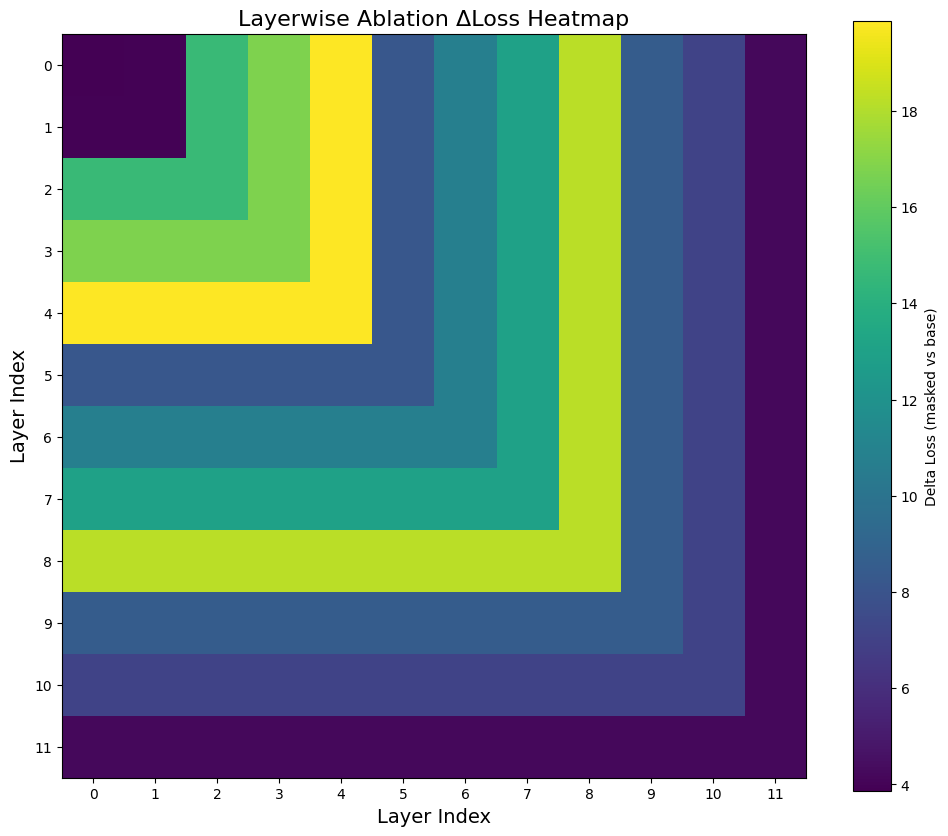

In [12]:
plot_ablation_heatmap("my_ablation_results.json")


In [13]:
from transformers import BitsAndBytesConfig

model_name = "gpt2"
input_text = "The theory of relativity was proposed by"

# Example quantization config (optional)
quant_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.bfloat16)

# Create the study object
ablation_study = LayerwiseAblationStudy(
    model_name=model_name,
    quantization_config=quant_config,
    max_combination_size=4,   # (careful, combinations grow fast!)
    output_file="my_ablation_results-4.json"
)

ablation_study.load_model()
results = ablation_study.ablation_study(input_text)


✅ Loaded model gpt2 with quantization: BitsAndBytesConfig {
  "_load_in_4bit": true,
  "_load_in_8bit": false,
  "bnb_4bit_compute_dtype": "bfloat16",
  "bnb_4bit_quant_storage": "uint8",
  "bnb_4bit_quant_type": "fp4",
  "bnb_4bit_use_double_quant": false,
  "llm_int8_enable_fp32_cpu_offload": false,
  "llm_int8_has_fp16_weight": false,
  "llm_int8_skip_modules": null,
  "llm_int8_threshold": 6.0,
  "load_in_4bit": true,
  "load_in_8bit": false,
  "quant_method": "bitsandbytes"
}

🔍 Starting ablation study (max_combination_size=4)...
🎯 Base loss: 4.1332
📚 Total layers: 12
⚡ Masking layers: (0,)
⚡ Masking layers: (1,)
⚡ Masking layers: (2,)
⚡ Masking layers: (3,)
⚡ Masking layers: (4,)
⚡ Masking layers: (5,)
⚡ Masking layers: (6,)
⚡ Masking layers: (7,)
⚡ Masking layers: (8,)
⚡ Masking layers: (9,)
⚡ Masking layers: (10,)
⚡ Masking layers: (11,)
⚡ Masking layers: (0, 1)
⚡ Masking layers: (0, 2)
⚡ Masking layers: (0, 3)
⚡ Masking layers: (0, 4)
⚡ Masking layers: (0, 5)
⚡ Masking layers:

In [21]:
import json
import itertools
import numpy as np

def compute_shapley_values(result_file):
    # Load ablation results
    with open(result_file, "r") as f:
        data = json.load(f)

    results = data["results"]

    # Extract layers and their associated delta_loss and delta_perplexity
    layer_combinations_loss = {}
    layer_combinations_ppl = {}

    for key, value in results.items():
        layers = eval(key)  # Convert string representation to tuple (layer indices)
        delta_loss = value["delta_loss"]
        delta_perplexity = value.get("delta_perplexity", 0)  # In case old files don't have this
        layer_combinations_loss[layers] = delta_loss
        layer_combinations_ppl[layers] = delta_perplexity

    # Get all layers involved
    all_layers = set()
    for layers in layer_combinations_loss.keys():
        all_layers.update(layers)
    all_layers = sorted(list(all_layers))

    # Initialize dictionaries to store Shapley values
    shapley_values_loss = {layer: 0 for layer in all_layers}
    shapley_values_ppl = {layer: 0 for layer in all_layers}

    # Total number of combinations to consider
    num_combinations = 0

    # Loop over all non-empty subsets of layers
    for r in range(1, len(all_layers) + 1):
        for comb in itertools.combinations(all_layers, r):
            num_combinations += 1

            comb_loss = layer_combinations_loss.get(comb, 0)
            comb_ppl = layer_combinations_ppl.get(comb, 0)

            for layer in comb:
                reduced_comb = tuple(l for l in comb if l != layer)
                reduced_loss = layer_combinations_loss.get(reduced_comb, 0)
                reduced_ppl = layer_combinations_ppl.get(reduced_comb, 0)

                marginal_contribution_loss = comb_loss - reduced_loss
                marginal_contribution_ppl = comb_ppl - reduced_ppl

                shapley_values_loss[layer] += marginal_contribution_loss
                shapley_values_ppl[layer] += marginal_contribution_ppl

    # Normalize
    for layer in all_layers:
        shapley_values_loss[layer] /= num_combinations
        shapley_values_ppl[layer] /= num_combinations

    # Return both
    return {
        "shapley_values_loss": shapley_values_loss,
        "shapley_values_perplexity": shapley_values_ppl
    }


In [18]:
import json
import itertools
import numpy as np

def compute_shapley_values(result_file):
    # Load ablation results
    with open(result_file, "r") as f:
        data = json.load(f)

    results = data["results"]

    # Extract layers and their associated losses (delta_loss)
    layer_combinations = {}
    for key, value in results.items():
        layers = eval(key)  # Convert string representation to tuple (layer indices)
        delta_loss = value["delta_loss"]
        layer_combinations[layers] = delta_loss

    # Get all layers involved
    all_layers = set()
    for layers in layer_combinations.keys():
        all_layers.update(layers)
    all_layers = sorted(list(all_layers))

    # Initialize dictionary to store Shapley values
    shapley_values = {layer: 0 for layer in all_layers}

    # Total number of combinations to consider
    num_combinations = 0

    # Loop over all non-empty subsets of layers
    for r in range(1, len(all_layers) + 1):
        for comb in itertools.combinations(all_layers, r):
            num_combinations += 1
            comb_loss = layer_combinations.get(comb, 0)

            # For each layer, calculate marginal contribution
            for layer in comb:
                # Create a subset of the combination excluding the current layer
                reduced_comb = tuple(l for l in comb if l != layer)
                reduced_comb_loss = layer_combinations.get(reduced_comb, 0)

                # Calculate marginal contribution
                marginal_contribution = comb_loss - reduced_comb_loss
                shapley_values[layer] += marginal_contribution

    # Normalize by the number of combinations
    for layer in shapley_values:
        shapley_values[layer] /= num_combinations

    # Return Shapley values
    return shapley_values


In [22]:
shapley_values = compute_shapley_values("my_ablation_results-6.json")
print(shapley_values)


{'shapley_values_loss': {0: -0.7465437547336713, 1: -0.7464230479774895, 2: -0.738287915880718, 3: -0.7251384876586578, 4: -0.7371488947862525, 5: -0.7876204901125842, 6: -0.7652151326120118, 7: -0.8307760750417744, 8: -0.28745100716531496, 9: -1.1500605979681888, 10: -1.6434584329416464, 11: -2.6290034439100887}, 'shapley_values_perplexity': {0: -22891263.366552304, 1: -22891263.00768731, 2: -22877698.126822878, 3: -168114.46436002167, 4: -43538869.96042413, 5: -47737650.35606815, 6: -47695566.25684674, 7: -47791442.15695238, 8: 213524465.9919772, 9: -263272019.74682757, 10: -263515008.60909224, 11: -263544728.15855846}}


In [31]:
class TransformerBlockIdentity(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, hidden_states, *args, **kwargs):
        # Return in the same structure that original transformer blocks return
        # In most HuggingFace models: output is (hidden_states, present/past_key_values)
        return (hidden_states, None)


In [32]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

class ModelPruner:
    def __init__(self, model_name, shapley_loss_values, shapley_ppl_values, prune_mode="loss", prune_threshold=-1.0, max_layers_to_prune=None, quantization_config=None):
        """
        prune_mode: "loss" or "ppl" - based on which Shapley to prune
        prune_threshold: prune layers with shapley below this threshold
        max_layers_to_prune: prune top-k worst layers
        """
        self.model_name = model_name
        self.shapley_loss_values = shapley_loss_values
        self.shapley_ppl_values = shapley_ppl_values
        self.prune_mode = prune_mode
        self.prune_threshold = prune_threshold
        self.max_layers_to_prune = max_layers_to_prune
        self.quantization_config = quantization_config

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = None
        self.tokenizer = None

    def load_model(self):
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name, use_fast=True)
        self.model = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            device_map="auto",
            torch_dtype=torch.bfloat16 if self.quantization_config else torch.float32,
            quantization_config=self.quantization_config,
        )
        self.model.eval()

    def select_layers_to_prune(self):
        shapley_values = self.shapley_loss_values if self.prune_mode == "loss" else self.shapley_ppl_values
        
        # Sort by Shapley (ascending: more negative = worse)
        sorted_layers = sorted(shapley_values.items(), key=lambda x: x[1])

        if self.max_layers_to_prune:
            layers_to_prune = [layer for layer, _ in sorted_layers[:self.max_layers_to_prune]]
        else:
            layers_to_prune = [layer for layer, score in sorted_layers if score < self.prune_threshold]

        return layers_to_prune

    def prune_layers(self, layers_to_prune):
        print(f"🔪 Pruning layers: {layers_to_prune}")

        try:
            layer_list = self.model.model.layers  # LLaMA, OPT
        except AttributeError:
            layer_list = self.model.transformer.h  # GPT-2, DistilGPT2, etc.

        for idx in layers_to_prune:
            print(f"Zeroing Layer {idx}")
            layer_list[idx] = TransformerBlockIdentity()  # Replace the layer with Identity (no-op)

    def evaluate_model(self, input_text):
        inputs = self.tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512).to(self.device)

        with torch.no_grad():
            outputs = self.model(**inputs, labels=inputs["input_ids"])
            loss = outputs.loss.item()

        perplexity = torch.exp(outputs.loss).item()
        return loss, perplexity

    def run_pruning_experiment(self, input_text):
        self.load_model()
        layers_to_prune = self.select_layers_to_prune()
        self.prune_layers(layers_to_prune)

        loss, perplexity = self.evaluate_model(input_text)
        print(f"\n✅ After Pruning:\nLoss = {loss:.4f}\nPerplexity = {perplexity:.2f}")

        return loss, perplexity


In [33]:
shapley_values

{'shapley_values_loss': {0: -0.7465437547336713,
  1: -0.7464230479774895,
  2: -0.738287915880718,
  3: -0.7251384876586578,
  4: -0.7371488947862525,
  5: -0.7876204901125842,
  6: -0.7652151326120118,
  7: -0.8307760750417744,
  8: -0.28745100716531496,
  9: -1.1500605979681888,
  10: -1.6434584329416464,
  11: -2.6290034439100887},
 'shapley_values_perplexity': {0: -22891263.366552304,
  1: -22891263.00768731,
  2: -22877698.126822878,
  3: -168114.46436002167,
  4: -43538869.96042413,
  5: -47737650.35606815,
  6: -47695566.25684674,
  7: -47791442.15695238,
  8: 213524465.9919772,
  9: -263272019.74682757,
  10: -263515008.60909224,
  11: -263544728.15855846}}

In [34]:
# Assume you have shapley_loss_values and shapley_ppl_values dictionaries already loaded.

model_name = "gpt2"
input_text = "The theory of relativity was proposed by"

pruner = ModelPruner(
    model_name=model_name,
    shapley_loss_values=shapley_values['shapley_values_loss'],
    shapley_ppl_values=shapley_values[ 'shapley_values_perplexity'],
    prune_mode="loss",                # or "ppl"
    prune_threshold=-1.0,              # prune if Shapley < -1.0
    max_layers_to_prune=3,             # (optional) prune top-3 worst layers
    quantization_config=None
)

loss, ppl = pruner.run_pruning_experiment(input_text)


🔪 Pruning layers: [11, 10, 9]
Zeroing Layer 11
Zeroing Layer 10
Zeroing Layer 9

✅ After Pruning:
Loss = 5.3952
Perplexity = 220.35


In [38]:
import torch
import time
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch.nn as nn

# Minimal Identity block
class TransformerBlockIdentity(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, hidden_states, *args, **kwargs):
        return (hidden_states, None)

class ModelPruner:
    def __init__(self, model_name, shapley_loss_values, shapley_ppl_values,
                 prune_mode="loss", prune_threshold=-1.0, max_layers_to_prune=None, quantization_config=None):
        """
        prune_mode: "loss" or "ppl" - based on which Shapley to prune
        prune_threshold: prune layers with shapley below this threshold
        max_layers_to_prune: prune top-k worst layers
        """
        self.model_name = model_name
        self.shapley_loss_values = shapley_loss_values
        self.shapley_ppl_values = shapley_ppl_values
        self.prune_mode = prune_mode
        self.prune_threshold = prune_threshold
        self.max_layers_to_prune = max_layers_to_prune
        self.quantization_config = quantization_config

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = None
        self.tokenizer = None

    def load_model(self):
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name, use_fast=True)
        self.model = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            device_map="auto",
            torch_dtype=torch.bfloat16 if self.quantization_config else torch.float32,
            quantization_config=self.quantization_config,
        )
        self.model.eval()

    def select_layers_to_prune(self):
        shapley_values = self.shapley_loss_values if self.prune_mode == "loss" else self.shapley_ppl_values
        
        # Sort by Shapley (ascending: more negative = worse)
        sorted_layers = sorted(shapley_values.items(), key=lambda x: x[1])

        if self.max_layers_to_prune:
            layers_to_prune = [layer for layer, _ in sorted_layers[:self.max_layers_to_prune]]
        else:
            layers_to_prune = [layer for layer, score in sorted_layers if score < self.prune_threshold]

        return layers_to_prune

    def prune_layers(self, layers_to_prune):
        print(f"🔪 Pruning layers: {layers_to_prune}")

        try:
            layer_list = self.model.model.layers  # LLaMA, OPT
        except AttributeError:
            layer_list = self.model.transformer.h  # GPT-2, DistilGPT2, etc.

        for idx in layers_to_prune:
            print(f"Zeroing Layer {idx}")
            layer_list[idx] = TransformerBlockIdentity()

    def evaluate_model(self, input_text):
        inputs = self.tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512).to(self.device)

        start_time = time.time()
        with torch.no_grad():
            outputs = self.model(**inputs, labels=inputs["input_ids"])
            loss = outputs.loss.item()
        end_time = time.time()

        inference_time = end_time - start_time
        perplexity = torch.exp(outputs.loss).item()
        return loss, perplexity, inference_time

    def run_pruning_experiment(self, input_text):
        # Load and evaluate original model
        self.load_model()
        original_loss, original_perplexity, original_time = self.evaluate_model(input_text)
        print(f"\n🏋️ Before Pruning:\nLoss = {original_loss:.4f}, Perplexity = {original_perplexity:.2f}, Inference Time = {original_time:.4f} sec")

        # Prune layers
        layers_to_prune = self.select_layers_to_prune()
        self.prune_layers(layers_to_prune)

        # Evaluate pruned model
        pruned_loss, pruned_perplexity, pruned_time = self.evaluate_model(input_text)
        print(f"\n✅ After Pruning:\nLoss = {pruned_loss:.4f}, Perplexity = {pruned_perplexity:.2f}, Inference Time = {pruned_time:.4f} sec")

        return {
            "before": {
                "loss": original_loss,
                "perplexity": original_perplexity,
                "inference_time_sec": original_time
            },
            "after": {
                "loss": pruned_loss,
                "perplexity": pruned_perplexity,
                "inference_time_sec": pruned_time
            }
        }


In [39]:
# Assume shapley_values dict already loaded:
# shapley_values['shapley_values_loss'] and shapley_values['shapley_values_perplexity']

model_name = "gpt2"
input_text = "The theory of relativity was proposed by"

pruner = ModelPruner(
    model_name=model_name,
    shapley_loss_values=shapley_values['shapley_values_loss'],
    shapley_ppl_values=shapley_values['shapley_values_perplexity'],
    prune_mode="loss",                # or "ppl"
    prune_threshold=-1.0,              # prune if Shapley < -1.0
    max_layers_to_prune=3,             # (optional) prune top-3 worst layers
    quantization_config=None
)

results = pruner.run_pruning_experiment(input_text)

print("\n📈 Results Comparison:")
print(f"Before pruning - Loss: {results['before']['loss']:.4f}, Perplexity: {results['before']['perplexity']:.2f}, Inference Time: {results['before']['inference_time_sec']:.4f} sec")
print(f"After pruning  - Loss: {results['after']['loss']:.4f}, Perplexity: {results['after']['perplexity']:.2f}, Inference Time: {results['after']['inference_time_sec']:.4f} sec")



🏋️ Before Pruning:
Loss = 3.9919, Perplexity = 54.16, Inference Time = 0.2952 sec
🔪 Pruning layers: [11, 10, 9]
Zeroing Layer 11
Zeroing Layer 10
Zeroing Layer 9

✅ After Pruning:
Loss = 5.3952, Perplexity = 220.35, Inference Time = 0.0347 sec

📈 Results Comparison:
Before pruning - Loss: 3.9919, Perplexity: 54.16, Inference Time: 0.2952 sec
After pruning  - Loss: 5.3952, Perplexity: 220.35, Inference Time: 0.0347 sec
